# **Black-box Watermarking**

Most of the existing watermarking specially to protect the integrity involves manipulating the CNN model hidden layers to insert the signature. While they provide reasonable integrity protection, but nevertheless they may negatively impact the accuracy of the model. Therefore, our aim in this project is to develop a watermarking mechanism to ensure CNN integrity without manipulating the model layers. In addition, the aim is to produce a watermark that can work on CNN in a Blackbox manner during inference/query time to check the CNN models in their running time. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
%cd gdrive/MyDrive/disentangling-vae/

/content/gdrive/MyDrive/disentangling-vae/classifers


In [2]:
import torch
import time
import copy
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim

from tqdm import tqdm

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else: 
  print("CPU")

#print(models.resnet18())

GPU


**Load** the datasets here in the cell below

In [3]:
mnist_classes = 10
Fmnist_classes = 10

mnist_batch = 128
Fmnist_batch = 128

mnist_epoch = 6
Fmnist_epoch = 8

criterion = nn.CrossEntropyLoss()

In [4]:
#input_size = 224        #for  ResNet and VGG
transforms_1 = transforms.Compose([transforms.Resize(32),transforms.ToTensor()])


mnist_trainset_i = datasets.MNIST(root='./data', train=True, download=True, transform=transforms_1)
mnist_trainset = DataLoader(mnist_trainset_i,batch_size = mnist_batch,shuffle=True)

mnist_testset_i = datasets.MNIST(root='./data', train=False, download=True, transform=transforms_1)
mnist_testset = DataLoader(mnist_testset_i,batch_size = mnist_batch,shuffle=True)

"""

Fmnist_trainset_i = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms_1)
Fmnist_trainset = DataLoader(Fmnist_trainset_i,batch_size = Fmnist_batch,shuffle=True)

Fmnist_testset_i = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms_1)
Fmnist_testset = DataLoader(Fmnist_testset_i,batch_size = Fmnist_batch,shuffle=True)
"""
print(torch.cuda.memory_allocated(device))

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

0


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
def train_model(model,train_set,test_set,optimizer,num_epochs):
  since = time.time()

  batch_train_loss = []
  acc_epoch_train = []
  acc_epoch_val = []

  best_model_wts = copy.deepcopy(model.state_dict())            #copy the model here
  best_acc = 0.0
  
  for epoch in tqdm(range(num_epochs)):
    print('\nEpoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    batch = 0
    prev_loss = 0
    #train step starts here.
    model.train()                                               
    train_loss = 0.0
    train_corrects = 0

    for inputs,labels in train_set:
      
      inputs = inputs.to(device)
      labels = labels.to(device)

      #print(torch.cuda.memory_allocated(device))
      optimizer.zero_grad()
      torch.set_grad_enabled(True)

      outputs = model(inputs)
      loss = criterion(outputs, labels)         #cross entropy loss
      _, preds = torch.max(outputs, 1) 

      loss.backward()
      optimizer.step()
      
      train_loss += loss.item() * inputs.size(0)
      train_corrects += torch.sum(preds == labels.data)
      batch_train_loss.append(train_loss - prev_loss)
      print('Training batch number: {} : loss --> {}'.format(batch,train_loss-prev_loss))
      prev_loss = train_loss
      batch = batch+1

    epoch_train_loss = train_loss / len(train_set.dataset)
    epoch_train_acc = train_corrects.double() / len(train_set.dataset)
    acc_epoch_train.append(epoch_train_acc)

    print('\n\n{} Loss: {:.4f} Acc: {:.4f}'.format("Training..", epoch_train_loss, epoch_train_acc))

    #evaluation starts here...
    batch = 0
    prev_loss = 0
    model.eval()                
    testing_loss = 0.0
    testing_corrects = 0

    for inputs,labels in test_set:
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      torch.set_grad_enabled(False)
      
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

      testing_loss += loss.item() * inputs.size(0)
      testing_corrects += torch.sum(preds == labels.data)
      print('Validating batch number: {} : loss --> {}'.format(batch,testing_loss - prev_loss))
      prev_loss = testing_loss
      batch = batch+1
    #evaluation is over here...

    epoch_testing_loss = testing_loss / len(test_set.dataset)
    epoch_testing_acc = testing_corrects.double() / len(test_set.dataset)
    acc_epoch_val.append(epoch_testing_acc)
    print('{} Loss: {:.4f} Acc: {:.4f}'.format("Testing..", epoch_testing_loss, epoch_testing_acc))

    if epoch_testing_acc > best_acc:
      best_acc = epoch_testing_acc
      best_model_wts = copy.deepcopy(model.state_dict())

  print('\n\n Training complete in {:.4f}seconds',time.time() - since)

  model.load_state_dict(best_model_wts)
  return model,batch_train_loss,acc_epoch_train,acc_epoch_val

print(torch.cuda.memory_allocated(device))

0


**Load** the pretrained models here.

In [9]:
PATH = 'classifers/net_architecture.pth'
clean_model = torch.load(PATH,map_location=torch.device('cpu'))
attacked_model = torch.load(PATH,map_location=torch.device('cpu'))

PATH = 'classifers/net.pth'
clean_model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))

PATH = "classifers/square_white_tar0_alpha0.00_mark(3,3).pth"
attacked_model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))

Mresnet18 = clean_model

"""
Fresnet18 = models.resnet18(pretrained=True)          #for FashionMNIST
Fresnet18.fc = nn.Linear(512,Fmnist_classes)
Fresnet18.conv1 = nn.Conv2d(1, 64,kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


Mvgg13 = models.vgg13(pretrained=True)
Mvgg13.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Mvgg13.classifier[6] = nn.Linear(4096,mnist_classes)


Fvgg13 = models.vgg13(pretrained = True)
Fvgg13.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Fvgg13.classifier[6] = nn.Linear(4096,Fmnist_classes)

"""
print(torch.cuda.memory_allocated(device))

ModuleNotFoundError: ignored

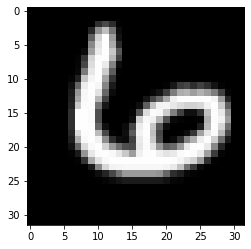

318335488


In [ ]:
img_xy = np.random.randint(len(mnist_testset_i));
img = mnist_testset_i[img_xy][0][0,:,:]
plt.imshow(img, cmap='gray')
plt.show()

"""
img_xy = np.random.randint(len(Fmnist_testset_i));
img = Fmnist_testset_i[img_xy][0][0,:,:]
plt.imshow(img, cmap='gray')
plt.show()
"""
print(torch.cuda.memory_allocated(device))

  0%|          | 0/7 [00:00<?, ?it/s]


Epoch 0/6
----------
Training batch number: 0 : loss --> 322.0579833984375
Training batch number: 1 : loss --> 368.2408447265625
Training batch number: 2 : loss --> 260.0546875
Training batch number: 3 : loss --> 222.90234375
Training batch number: 4 : loss --> 190.40892028808594
Training batch number: 5 : loss --> 121.91690063476562
Training batch number: 6 : loss --> 180.73611450195312
Training batch number: 7 : loss --> 464.77801513671875
Training batch number: 8 : loss --> 249.01324462890625
Training batch number: 9 : loss --> 193.13531494140625
Training batch number: 10 : loss --> 160.20748901367188
Training batch number: 11 : loss --> 123.98138427734375
Training batch number: 12 : loss --> 117.88411712646484
Training batch number: 13 : loss --> 114.49777221679688
Training batch number: 14 : loss --> 98.19363403320312
Training batch number: 15 : loss --> 55.56158447265625
Training batch number: 16 : loss --> 46.55664825439453
Training batch number: 17 : loss --> 53.53532409667969

 14%|█▍        | 1/7 [00:29<02:54, 29.07s/it]

Validating batch number: 70 : loss --> 20.767513275146484
Validating batch number: 71 : loss --> 14.918415069580078
Validating batch number: 72 : loss --> 21.744657516479492
Validating batch number: 73 : loss --> 20.73491668701172
Validating batch number: 74 : loss --> 26.411731719970703
Validating batch number: 75 : loss --> 23.966720581054688
Validating batch number: 76 : loss --> 6.248996734619141
Validating batch number: 77 : loss --> 26.451736450195312
Validating batch number: 78 : loss --> 4.832505226135254
Testing.. Loss: 0.1468 Acc: 0.9558

Epoch 1/6
----------
Training batch number: 0 : loss --> 13.347970008850098
Training batch number: 1 : loss --> 16.470138549804688
Training batch number: 2 : loss --> 11.685773849487305
Training batch number: 3 : loss --> 11.720813751220703
Training batch number: 4 : loss --> 6.150473594665527
Training batch number: 5 : loss --> 6.731794834136963
Training batch number: 6 : loss --> 6.48577880859375
Training batch number: 7 : loss --> 5.63801

 29%|██▊       | 2/7 [00:57<02:24, 28.91s/it]

Validating batch number: 74 : loss --> 1.861401915550232
Validating batch number: 75 : loss --> 5.753533363342285
Validating batch number: 76 : loss --> 0.8456918597221375
Validating batch number: 77 : loss --> 3.675405502319336
Validating batch number: 78 : loss --> 1.0668883323669434
Testing.. Loss: 0.0317 Acc: 0.9909

Epoch 2/6
----------
Training batch number: 0 : loss --> 0.2511656880378723
Training batch number: 1 : loss --> 0.6392956972122192
Training batch number: 2 : loss --> 16.077308654785156
Training batch number: 3 : loss --> 5.43925142288208
Training batch number: 4 : loss --> 4.05754280090332
Training batch number: 5 : loss --> 5.754485130310059
Training batch number: 6 : loss --> 5.272332191467285
Training batch number: 7 : loss --> 5.922573566436768
Training batch number: 8 : loss --> 0.45090344548225403
Training batch number: 9 : loss --> 4.3552656173706055
Training batch number: 10 : loss --> 3.423917055130005
Training batch number: 11 : loss --> 2.096402168273926
Tr

 43%|████▎     | 3/7 [01:26<01:55, 28.76s/it]

Testing.. Loss: 0.0511 Acc: 0.9862

Epoch 3/6
----------
Training batch number: 0 : loss --> 4.299592971801758
Training batch number: 1 : loss --> 3.850473642349243
Training batch number: 2 : loss --> 0.08634919673204422
Training batch number: 3 : loss --> 1.8260523080825806
Training batch number: 4 : loss --> 0.903410792350769
Training batch number: 5 : loss --> 3.700014114379883
Training batch number: 6 : loss --> 1.310125708580017
Training batch number: 7 : loss --> 5.689643383026123
Training batch number: 8 : loss --> 0.5255649089813232
Training batch number: 9 : loss --> 2.13242769241333
Training batch number: 10 : loss --> 2.6768507957458496
Training batch number: 11 : loss --> 4.320952892303467
Training batch number: 12 : loss --> 8.906730651855469
Training batch number: 13 : loss --> 5.088099479675293
Training batch number: 14 : loss --> 1.8690460920333862
Training batch number: 15 : loss --> 5.5034098625183105
Training batch number: 16 : loss --> 1.5200527906417847
Training ba

 57%|█████▋    | 4/7 [01:54<01:26, 28.70s/it]

Validating batch number: 72 : loss --> 1.2762668132781982
Validating batch number: 73 : loss --> 7.747483253479004
Validating batch number: 74 : loss --> 2.0548946857452393
Validating batch number: 75 : loss --> 1.15261971950531
Validating batch number: 76 : loss --> 3.6605753898620605
Validating batch number: 77 : loss --> 1.9402215480804443
Validating batch number: 78 : loss --> 0.011582870967686176
Testing.. Loss: 0.0249 Acc: 0.9924

Epoch 4/6
----------
Training batch number: 0 : loss --> 2.730466365814209
Training batch number: 1 : loss --> 6.192716598510742
Training batch number: 2 : loss --> 3.849557876586914
Training batch number: 3 : loss --> 2.912607431411743
Training batch number: 4 : loss --> 0.3933674395084381
Training batch number: 5 : loss --> 0.5128409266471863
Training batch number: 6 : loss --> 0.21603743731975555
Training batch number: 7 : loss --> 3.7326815128326416
Training batch number: 8 : loss --> 2.470991373062134
Training batch number: 9 : loss --> 0.830787301

 71%|███████▏  | 5/7 [02:23<00:57, 28.66s/it]

Validating batch number: 77 : loss --> 1.5021696090698242
Validating batch number: 78 : loss --> 0.06116839870810509
Testing.. Loss: 0.0273 Acc: 0.9920

Epoch 5/6
----------
Training batch number: 0 : loss --> 1.5795648097991943
Training batch number: 1 : loss --> 0.06349880248308182
Training batch number: 2 : loss --> 5.298452377319336
Training batch number: 3 : loss --> 0.22548341751098633
Training batch number: 4 : loss --> 1.1875203847885132
Training batch number: 5 : loss --> 0.12815478444099426
Training batch number: 6 : loss --> 2.8582801818847656
Training batch number: 7 : loss --> 0.28668782114982605
Training batch number: 8 : loss --> 0.07430735975503922
Training batch number: 9 : loss --> 0.03806587681174278
Training batch number: 10 : loss --> 0.046730320900678635
Training batch number: 11 : loss --> 1.3055768013000488
Training batch number: 12 : loss --> 3.0599610805511475
Training batch number: 13 : loss --> 1.949658989906311
Training batch number: 14 : loss --> 0.3684737

 86%|████████▌ | 6/7 [02:51<00:28, 28.61s/it]

Validating batch number: 71 : loss --> 0.06507963687181473
Validating batch number: 72 : loss --> 0.08361772447824478
Validating batch number: 73 : loss --> 6.616591930389404
Validating batch number: 74 : loss --> 1.9971903562545776
Validating batch number: 75 : loss --> 0.04359527677297592
Validating batch number: 76 : loss --> 1.4129408597946167
Validating batch number: 77 : loss --> 1.9189790487289429
Validating batch number: 78 : loss --> 0.000441500247688964
Testing.. Loss: 0.0227 Acc: 0.9934

Epoch 6/6
----------
Training batch number: 0 : loss --> 0.10448864102363586
Training batch number: 1 : loss --> 1.9639939069747925
Training batch number: 2 : loss --> 0.12282001227140427
Training batch number: 3 : loss --> 0.06233997270464897
Training batch number: 4 : loss --> 1.018123745918274
Training batch number: 5 : loss --> 0.48233669996261597
Training batch number: 6 : loss --> 0.056103453040122986
Training batch number: 7 : loss --> 0.7025155425071716
Training batch number: 8 : los

100%|██████████| 7/7 [03:20<00:00, 28.59s/it]

Validating batch number: 78 : loss --> 0.09782351553440094
Testing.. Loss: 0.0649 Acc: 0.9825


 Training complete in {:.4f}seconds 200.14584755897522


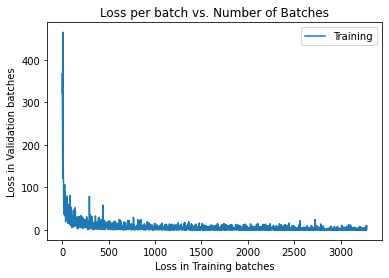

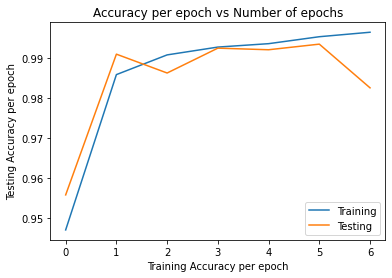

In [ ]:
#title
Mresnet18.to(device)
optimizer_ft = optim.Adadelta(Mresnet18.parameters())
trained_MResnet,MRbatch_train_loss,MRacc_epoch_train,MRacc_epoch_val = train_model(Mresnet18,mnist_trainset,mnist_testset,optimizer_ft,mnist_epoch)

plt.title("Loss per batch vs. Number of Batches")
plt.xlabel("Loss in Training batches")
plt.ylabel("Loss in Validation batches")
plt.plot(MRbatch_train_loss,label = "Training")
plt.legend()
plt.show()

plt.title("Accuracy per epoch vs Number of epochs")
plt.xlabel("Training Accuracy per epoch")
plt.ylabel("Testing Accuracy per epoch")
plt.plot(MRacc_epoch_train,label = "Training")
plt.plot(MRacc_epoch_val,label = "Testing")
plt.legend()
plt.show()

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

model_save_name = 'mnist_resnet18.pth'
path = F"/content/gdrive/My Drive/disentangling-vae/classifers/{model_save_name}" 
torch.save(trained_MResnet.state_dict(), path)

In [ ]:
#@title
model_save_name = 'MResnet18.pt'
path = F"/content/gdrive/My Drive/Trained_models/{model_save_name}" 
torch.save(Mresnet18.state_dict(), path)

In [ ]:
#@title
Fresnet18.to(device)
optimizer_ft = optim.Adadelta(Fresnet18.parameters())
trained_FResnet,FRbatch_train_loss,FRacc_epoch_train,FRacc_epoch_val = train_model(Fresnet18,Fmnist_trainset,Fmnist_testset,optimizer_ft,Fmnist_epoch)

plt.title("Loss per batch vs. Number of Batches")
plt.xlabel("Loss in Training batches")
plt.ylabel("Loss in Validation batches")
plt.plot(FRbatch_train_loss,label = "Training")
plt.legend()
plt.show()

plt.title("Accuracy per epoch vs Number of epochs")
plt.xlabel("Training Accuracy per epoch")
plt.ylabel("Testing Accuracy per epoch")
plt.plot(FRacc_epoch_train,label = "Training")
plt.plot(FRacc_epoch_val,label = "Testing")
plt.legend()
plt.show()

In [ ]:
#@title
model_save_name = 'FResnet18.pt'
path = F"/content/gdrive/My Drive/Trained_models/{model_save_name}" 
torch.save(Fresnet18.state_dict(), path)

In [ ]:
#@title
Mvgg13.to(device)
optimizer_ft = optim.Adadelta(Mvgg13.parameters())
print(torch.cuda.memory_allocated(device))
trained_Mvgg13,MVbatch_train_loss,MVacc_epoch_train,MVacc_epoch_val = train_model(Mvgg13,mnist_trainset,mnist_testset,optimizer_ft,mnist_epoch)

plt.title("Loss per batch vs. Number of Batches")
plt.xlabel("Loss in Training batches")
plt.ylabel("Loss in Validation batches")
plt.plot(MVbatch_train_loss,label = "Training")
plt.legend()
plt.show()

plt.title("Accuracy per epoch vs Number of epochs")
plt.xlabel("Training Accuracy per epoch")
plt.ylabel("Testing Accuracy per epoch")
plt.plot(MVacc_epoch_train,label = "Training")
plt.plot(MVacc_epoch_val,label = "Testing")
plt.legend()
plt.show()

In [ ]:
#@title
model_save_name = 'Mvgg13.pt'
path = F"/content/gdrive/My Drive/Trained_models/{model_save_name}" 
torch.save(Mvgg13.state_dict(), path)

In [ ]:
Fvgg13.to(device)
optimizer_ft = optim.Adadelta(Fvgg13.parameters())
trained_Fvgg13,FVbatch_train_loss,FVacc_epoch_train,FVacc_epoch_val = train_model(Fvgg13,Fmnist_trainset,Fmnist_testset,optimizer_ft,Fmnist_epoch)

plt.title("Loss per batch vs. Number of Batches")
plt.xlabel("Loss in Training batches")
plt.ylabel("Loss in Validation batches")
plt.plot(FVbatch_train_loss,label = "Training")
plt.legend()
plt.show()

plt.title("Accuracy per epoch vs Number of epochs")
plt.xlabel("Training Accuracy per epoch")
plt.ylabel("Testing Accuracy per epoch")
plt.plot(FVacc_epoch_train,label = "Training")
plt.plot(FVacc_epoch_val,label = "Testing")
plt.legend()
plt.show()